In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gym
import numpy as np
import os
import ptan

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections

import seaborn as sns

sns.set_style('darkgrid')

## Solving the System of Equations

$\ddot{r} = - g$

### System of Equations

$y_0 = r$

$y_1 = \dot{r}$

---


$\dot{y}_0 = y_1$

$\dot{y}_1 =  -g$

In [108]:
class UniformGravity(gym.Env):
    metadata = {'render.modes': ['human']}
    
    # dt_s -- is the time step in seconds.
    def __init__(self, g = 9.8,  dt = 1.0, target_alt = 2.0, 
                 thrust_gs= 1.5, verbose = False, 
                 record_history = True, record_rate = 100):
        
        super(UniformGravity, self).__init__()
        self.record_rate = record_rate
        self.max_thrust = g*1.5
    
        # Actions
        self.action_space = gym.spaces.Box(low=np.array([-self.max_thrust]), 
                                           high=np.array([self.max_thrust]), 
                                           dtype=np.float32)
        
        # Obs (r,rdot,theta,theta_dot)
        self.observation_space = gym.spaces.Box(low=np.array([0,0]), 
                                                high=np.array([10**9,10**9]), 
                                                dtype=np.float32)
        
        self.record_history = record_history
        
        # setting the target altitude in natural units
        self.target_alt = target_alt
        
        self.dt = dt
        self.g = g
        
        self.max_time = 100.
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.steps = 0
        
        # Translational Coordinates
        self.r = 0.0
        self.r_dot = np.random.random()
        self.r_double_dot = 0.0

        self.elapsed_time = 0.0 # elapsed sim time in seconds
        
        # initialize the history array
        if self.record_history:
            self.trajectory = np.array([[self.r,self.r_dot]])
        
        obs = np.array([self.r,self.r_dot])
        
        return obs
    
    # continous actions = (mean thrust, mean counter clockwise rotation thrust)
    def step(self, action):
        
        # actions segragation
        thrust = np.clip(action[0]*self.max_thrust, -self.max_thrust, self.max_thrust)

        # Execute one time step within the environment using RK4
        self.elapsed_time += self.dt

        # integrate
        y0_k1 = self.r_dot
        y1_k1 = -self.g + thrust
        
        y0_k2 = (self.r_dot + y1_k1*self.dt/2)
        y1_k2 = -self.g + thrust
         
        y0_k3 = (self.r_dot + y1_k2*self.dt/2)
        y1_k3 = -self.g + thrust
          
        y0_k4 = (self.r_dot + y1_k3*self.dt)
        y1_k4 = -self.g + thrust

        # Update 
        self.r = self.r + self.dt/6*(y0_k1 + 2*y0_k2 + 2*y0_k3 + y0_k4)
        self.r_dot = self.r_dot + self.dt/6*(y1_k1 + 2*y1_k2 + 2*y1_k3 + y1_k4)
        
        # prepare to output
        obs = np.array([self.r,self.r_dot])
        
        # If recording is enabled record the trajectory
        if (self.record_history) and (self.steps % self.record_rate == 0):
            self.trajectory = np.append(self.trajectory,[[self.r,self.r_dot]],axis=0)
        
        # reward -1 for every step not done, encoruging getting to the optima
        # as fast as possible
        # plus a reward for every step near the target altitude
        reward = np.exp(-0.1*(self.r - self.target_alt)**2) - 0.05*(action[0]-self.g/self.max_thrust)*2
        
        # set if at the terminal state
        done = False
        
        if self.r < 0.0:
            done = True
        
        if (self.elapsed_time > self.max_time):
            done = True
        
        return (obs, reward, done, {})
    
    def render(self, size=5, sample_traj_rate = 1):
        pass

## Example Policy

In [109]:
env = UniformGravity(dt = 0.01, verbose=True, target_alt = 1.0)

find $a(t)$ such that we minimize $T$ where $T$ is the point where

$x(T) = h, \ \dot{x}(T) = 0, \ddot{x}(T) = 0$

such that the following constraints are satisfied,

$\ddot{x} = -g + a(t)$

$x(0) = 0, \ \dot{x}(0) = 0$

### Solution

$ {\rm min} \ J[a(t),T,\lambda_1,\lambda_2, \lambda_3, \lambda(t), x(t)] = T - \lambda_1 \left( \int_0^T \int_0^t (-g + a(t'))dt' dt - h\right) - \lambda_2 \left(\int_0^T (-g + a(t)) dt \right)- \lambda_3 (-g + a(T)) - \int_0^T(\lambda(t)(\ddot{x}(t) + g - a(t)) dt$


$ \delta J = \delta T - (\delta \lambda_1) (...) - (\delta \lambda_2)(...)-(\delta \lambda_3)(...) - \lambda_1 (\delta T \int_0^T (-g + a(t'))dt') - \lambda_1 (\int_0^T \int_0^t ( \delta a(t'))dt' dt) -  \delta T \lambda_2 (-g + a(T)) - \lambda_2 \int_0^T \delta a(t) dt - \delta T \lambda(T)(\ddot{x}(T) + g - a(T)) - \int_0^T(\delta\lambda(t)(\ddot{x}(t) + g - a(t)) dt -  \int_0^T(\lambda(t)(\ddot{\delta x}(t) - \delta a(t)) dt - \lambda_3 (a'(T)\delta T) - \lambda_3 \delta a(T)$

---

$\frac{\delta J}{\delta T} = 1 - \lambda_1 \int_0^T (-g + a(t'))dt' - \lambda_2 \left(-g + a(T) \right) + \lambda(T)(\ddot{x}(T) + g - a(T)) - \lambda_3 a'(T) = 0$

the derivatives wrt to $\lambda_2, \lambda_3, \lambda(t)$ simplify to the final constraints, and dynamics constraints this simplifies the above to

$ \lambda_3  = \frac{1}{a'(T)}$

---

$\frac{\delta J}{\delta a(y)} = -\lambda_1 \int_0^T \int_0^t \delta(t'-y) dt' dt - \lambda_2 \int_0^T \delta(t-y) dt + \int_0^T\lambda(t) \delta(t-y) dt  -\lambda_3 \delta(T-y) = 0$


$-\lambda_1 \int_0^T  I(0 \leq y \leq t) dt - \lambda_2 I(0 \leq y \leq T) + \lambda(y) I(0 \leq y \leq T) = 0$

choose $y$ such that $0 \leq y < T$

$\lambda_1 (T-y) + \lambda_2 = \lambda(y)$

---

$\frac{\delta J}{\delta x(y)} = $

---

$\frac{\delta J}{\delta \lambda_1} \rightarrow \int_0^T \int_0^t a(t')dt'dt = h + \frac{1}{2} g T^2$



In [81]:
env.reset()

d = False

while True:
    if env.elapsed_time < 8:
        a = [9.82/env.max_thrust]
    elif env.elapsed_time < 9.0:
        a = [9.6395/env.max_thrust]
    else:
        a = [9.8/env.max_thrust]
        
    s,r,d,_ = env.step(a)
    if d:
        break

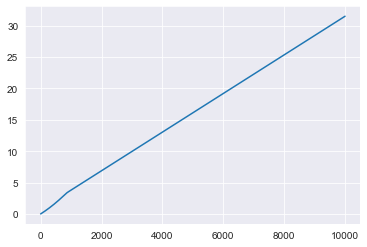

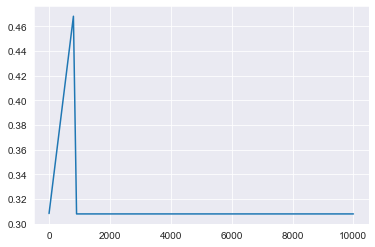

In [82]:
plt.plot(env.trajectory[:,0])
plt.show();

plt.plot(env.trajectory[:,1])
plt.show();

In [103]:
def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    # play count episodes
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs])
            obs_v = obs_v.to(device)
            mu_v = net(obs_v)
            mu_v = torch.clamp(mu_v, min=-env.max_thrust, max=env.max_thrust)
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            state, reward, done, _ = env.step(action)
            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count

def unpack_batch_ddqn(batch, device="cpu"):
    states, actions, rewards, dones, last_states = [], [], [], [], []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        dones.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = ptan.agent.float32_preprocessor(actions).to(device)
    rewards_v = ptan.agent.float32_preprocessor(rewards).to(device)
    last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
    dones_t = torch.BoolTensor(dones).to(device)
    return states_v, actions_v, rewards_v, dones_t, last_states_v

In [104]:
HIDDEN_SIZE = 128

class DDPGActor(nn.Module):
    def __init__(self, obs_size, act_size, device):
        super(DDPGActor, self).__init__()

        self.bias_vector = torch.FloatTensor([0.0]).to(device)
        
        self.net = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, act_size),
            nn.Tanh()
        )

    def forward(self, x):
        return(self.net(x) + self.bias_vector)


class DDPGCritic(nn.Module):
    def __init__(self, obs_size, act_size):
        super(DDPGCritic, self).__init__()

        self.obs_net = nn.Sequential(
            nn.Linear(obs_size, HIDDEN_SIZE),
            nn.ReLU(),
        )

        self.out_net = nn.Sequential(
            nn.Linear(HIDDEN_SIZE + act_size, HIDDEN_SIZE//2),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE//2, 1)
        )

    def forward(self, x, a):
        obs = self.obs_net(x)
        return self.out_net(torch.cat([obs, a], dim=1))

In [105]:
class AgentDDPG(ptan.agent.BaseAgent):
    """
    Agent implementing Orstein-Uhlenbeck exploration process
    """
    def __init__(self, net, device="cpu", ou_enabled=True, ou_mu=0.0, ou_teta=0.15, ou_sigma=0.2, ou_epsilon=1.0):
        self.net = net
        self.device = device
        self.ou_enabled = ou_enabled
        self.ou_mu = ou_mu
        self.ou_teta = ou_teta
        self.ou_sigma = ou_sigma
        self.ou_epsilon = ou_epsilon

    def initial_state(self):
        return None

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states).to(self.device)
        mu_v = self.net(states_v)
        actions = mu_v.data.cpu().numpy()
        actions += self.ou_sigma*np.random.normal(size=actions.shape[1])
        
        if self.ou_enabled and self.ou_epsilon > 0:
            new_a_states = []
            for a_state, action in zip(agent_states, actions):
                if a_state is None:
                    a_state = np.zeros(shape=action.shape, dtype=np.float32)
                a_state += self.ou_teta * (self.ou_mu - a_state)
                a_state += self.ou_sigma * np.random.normal(size=action.shape)

                action += self.ou_epsilon * a_state
                new_a_states.append(a_state)
        else:
            new_a_states = agent_states

        return actions, new_a_states

In [110]:
GAMMA = 0.99
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
REPLAY_SIZE = 100000
REPLAY_INITIAL = 5000

TEST_ITERS = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = UniformGravity(dt = 0.5, target_alt = 1.0, record_history = False)
test_env =  UniformGravity(dt = 0.5, target_alt = 1.0, record_history = False)

act_net = DDPGActor(env.observation_space.shape[0], env.action_space.shape[0], device).to(device)
crt_net = DDPGCritic(env.observation_space.shape[0], env.action_space.shape[0]).to(device)

tgt_act_net = ptan.agent.TargetNet(act_net)
tgt_crt_net = ptan.agent.TargetNet(crt_net)


agent = AgentDDPG(act_net, device=device)
exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, steps_count=1)
buffer = ptan.experience.ExperienceReplayBuffer(exp_source, buffer_size=REPLAY_SIZE)

act_opt = optim.Adam(act_net.parameters(), lr=LEARNING_RATE)
crt_opt = optim.Adam(crt_net.parameters(), lr=LEARNING_RATE)

frame_idx = 0
best_reward = None

In [95]:
s = env.reset()
s_v = torch.FloatTensor([s]).to(device)
act_net(s_v)

tensor([[0.1153]], device='cuda:0', grad_fn=<AddBackward0>)

In [111]:
while True:
    frame_idx += 1
    buffer.populate(1)
    #rewards_steps = exp_source.pop_rewards_steps()

    #if rewards_steps:
    #    rewards, steps = zip(*rewards_steps)
    #    tb_tracker.track("episode_steps", steps[0], frame_idx)
    #    tracker.reward(rewards[0], frame_idx)

    if len(buffer) < REPLAY_INITIAL:
        continue

    batch = buffer.sample(BATCH_SIZE)
    states_v, actions_v, rewards_v, dones_mask, last_states_v = \
        unpack_batch_ddqn(batch, device)

    # train critic
    crt_opt.zero_grad()

    q_v = crt_net(states_v, actions_v)
    last_act_v = tgt_act_net.target_model(last_states_v)
    
    q_last_v = tgt_crt_net.target_model(last_states_v, last_act_v)
    q_last_v[dones_mask] = 0.0
    q_ref_v = rewards_v.unsqueeze(dim=-1) + q_last_v * GAMMA

    critic_loss_v = F.mse_loss(q_v, q_ref_v.detach())
    critic_loss_v.backward()
    crt_opt.step()

    # train actor
    act_opt.zero_grad()

    cur_actions_v = act_net(states_v)
    actor_loss_v = -crt_net(states_v, cur_actions_v)
    actor_loss_v = actor_loss_v.mean()

    actor_loss_v.backward()
    act_opt.step()

    tgt_act_net.alpha_sync(alpha=1 - 1e-4)
    tgt_crt_net.alpha_sync(alpha=1 - 1e-4)

    if frame_idx % TEST_ITERS == 0:
        ts = time.time()
        rewards, steps = test_net(act_net, test_env, device=device)
        print("Test done in %.2f sec, reward %.3f, steps %d" % (
            time.time() - ts, rewards, steps))

        if best_reward is None or best_reward < rewards:
            if best_reward is not None:
                print("Best reward updated: %.3f -> %.3f" % (best_reward, rewards))
            best_reward = rewards

Test done in 0.01 sec, reward 0.852, steps 1
Test done in 1.03 sec, reward -3.957, steps 201
Test done in 1.01 sec, reward -4.821, steps 201
Test done in 1.17 sec, reward -4.881, steps 201
Test done in 1.00 sec, reward -4.903, steps 201
Test done in 0.99 sec, reward -4.961, steps 201
Test done in 0.99 sec, reward -4.921, steps 201
Test done in 1.09 sec, reward -4.937, steps 201
Test done in 1.06 sec, reward -4.919, steps 201
Test done in 1.01 sec, reward -4.985, steps 201
Test done in 0.98 sec, reward -4.997, steps 201
Test done in 0.99 sec, reward -4.954, steps 201
Test done in 1.15 sec, reward -4.941, steps 201
Test done in 0.98 sec, reward -4.943, steps 201
Test done in 0.97 sec, reward -4.973, steps 201
Test done in 0.99 sec, reward -1.355, steps 201
Test done in 1.05 sec, reward -2.154, steps 201
Test done in 1.10 sec, reward -1.972, steps 201
Test done in 0.99 sec, reward -1.769, steps 201
Test done in 0.99 sec, reward -1.234, steps 201
Test done in 0.98 sec, reward -1.513, steps

KeyboardInterrupt: 

In [112]:
rewards = 0.0
steps = 0
count = 10

trajectories = []
trajectories_act = []

# play count episodes
for _ in range(count):
    state = env.reset()
    traj = [state]
    traj_act = []
    print('----')
    while True:
        obs_v = ptan.agent.float32_preprocessor([state])
        obs_v = obs_v.to(device)
        mu_v = act_net(obs_v)
        action = mu_v.squeeze(dim=0).data.cpu().numpy()
        state, reward, done, _ = env.step(action)
        traj.append(state)
        traj_act.append(action[0])
        print('\t',action)
        rewards += reward
        steps += 1
        if done:
            break
    trajectories.append(traj)
    trajectories_act.append(traj_act)

trajectories = np.array(trajectories)
trajectories_act = np.array(trajectories_act)
(rewards / count, steps / count)

----
	 [0.75510186]
	 [0.5320636]
	 [0.57219577]
	 [0.6573249]
	 [0.6908827]
	 [0.6760273]
	 [0.6645702]
	 [0.6656273]
	 [0.66666913]
	 [0.66667837]
	 [0.66666687]
	 [0.66666657]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.6666665]
	 [0.6666668]
	 [0.66666657]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666675]
	 [0.6666665]
	 [0.6666668]
	 [0.66666657]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	

	 [0.6666665]
	 [0.66666675]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666675]
	 [0.6666665]
	 [0.6666668]
	 [0.66666657]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666675]
	 [0.66666657]
	 [0.6666666]
	 [0.66666675]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666657]
	 [0.6666668]
	 [0.66666657]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666675]
	 [0.66666657]
	 [0.6666666]
	 [0.66666675]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666657]
	 [0.6666668]
	 [0.66666657]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666675]
	 [0.66666657]
	 [0.6666666]
	 [0.66666675]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666657]
	 [0.6666668]
	 [0

	 [0.6666665]
	 [0.66666687]
	 [0.6666665]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.66666657]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666675]
	 [0.6666665]
	 [0.6666668]
	 [0.6666665]
	 [0.66666687]
	 [0.6666665]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.6666665]
	 [0.66666687]
	 [0.6666665]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.66666657]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.6666665]
	 [0.66666675]
	 [0.66666675]
	 [0.6666665]
	 [0.6666668]
	 [0.6666665]
	 [0.66666687]
	 [0.6666665]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [

	 [0.6666666]
	 [0.66666675]
	 [0.6666665]
	 [0.6666668]
	 [0.66666657]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.6666665]
	 [0.6666668]
	 [0.6666666]
	 [0.6666666]
	 [0.6666666]
	 [0.6666668]
	 [0.66666657]
	 [0.6666666]
	 [0.66666687]
	 [0.6666665]
	 [0.6666666]
	 [0.6666668]
	 [0.66666657]
	 [0.6666666]
	 [0.6666668]
	 [0.66666657]
	 [0.66666675]
	 [0.66666657]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.6666665]
	 [0.6666668]
	 [0.66666657]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.6666665]
	 [0.6666668]
	 [0.6666666]
	 [0.6666666]
	 [0.6666666]
	 [0.6666668]
	 [0.66666657]
	 [0.66666675]
	 [0.66666657]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.6666665]
	 [0.6666668]
	 [0.66666657]
	 [0.66666675]
	 [0.6666666]
	 [0.6666666]
	 [0.66666675]
	 [0.6666666]
	 [0.66666675]
	 [0.6666665]
	 [0.6

(200.92937018145193, 201.0)

(0, 25)

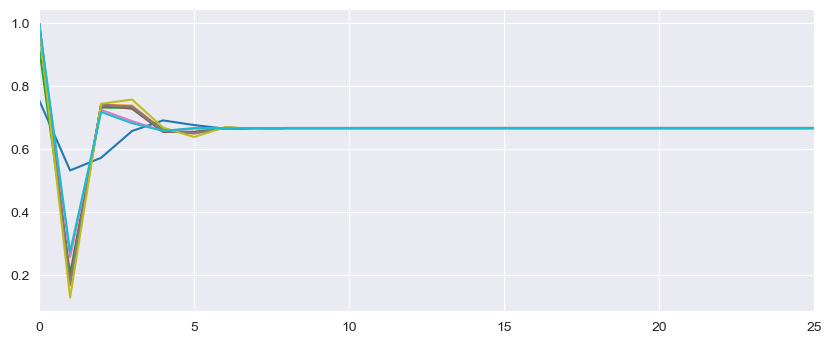

In [115]:
plt.figure(figsize=(10,4), dpi=100)
plt.plot( trajectories_act.T );
plt.xlim(0,25)

(0, 25)

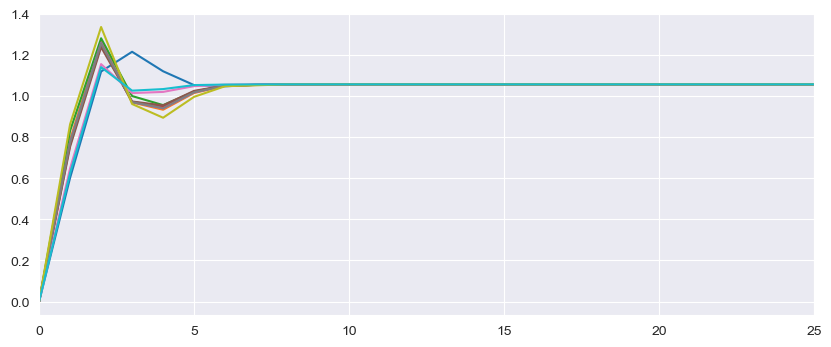

In [116]:
plt.figure(figsize=(10,4), dpi=100)
plt.plot( trajectories[:,:,0].T );
plt.xlim(0,25)

## Vanilla Policy Gradient Method

In [180]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using device: ',device)

HIDDEN_SIZE = 8

class PGN(nn.Module):
    def __init__(self, in_size, a_size):
        super(PGN,self).__init__()
        
        self.actions_mu = nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, a_size)
        )
    
        self.actions_var = nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, a_size)
        )
    
    def __call__(self, x):
        return (9.8+self.actions_mu(x)), (1+self.actions_var(x))
    
class AgentA2C(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu"):
        self.net = net
        self.device = device

    def __call__(self, states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)

        mu_v, var_v = self.net(states_v)
        mu = mu_v.data.cpu().numpy()[0]
        sigma = torch.sqrt(var_v).data.cpu().numpy()[0]
        actions = np.random.normal(mu, sigma)
        actions = np.clip(actions, a_min=-env.max_thrust, a_max=env.max_thrust)
        return actions

using device:  cpu


In [181]:
def compute_discounted_rewards(epi_rewards):
    batch_R = []
    R = 0.0
    for r in reversed(epi_rewards):
        R = r + GAMMA*R
        batch_R.append(R)
    q = list(reversed(batch_R))
    return q
    #q_mean = np.mean(q)
    #return [q_i - q_mean for q_i in q]
    
def calc_logprob(mu_v, var_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * np.pi * var_v))
    return p1 + p2

In [182]:
env = UniformGravity(dt = 0.5, target_alt = 1.0, record_history = False)

In [183]:
net = PGN(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
agent = AgentA2C(net, device=device)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [199]:
states = env.reset()

states_v = ptan.agent.float32_preprocessor([states])
states_v = states_v.to(device)

mu_v, var_v = net(states_v)
mu = mu_v.data.cpu().numpy()[0]
sigma = torch.sqrt(var_v).data.cpu().numpy()[0]

actions = np.random.normal(mu, sigma)
actions

array([12.63389776])

In [200]:
a = agent([state])
print(a)
new_state, r, done, _ = env.step(a)

(new_state, r, done)

[7.78768516]


(array([-0.25153935, -1.00615742]), -100.0, True)

In [201]:
ENTROPY_BETA = 1e-2

batch_states, batch_actions, batch_R = [], [], []
batch_rewards = []

total_rewards = collections.deque(maxlen=100)
batch_episodes = 0
done_episodes = 0
step_idx = 0
episode_length = 0

state = env.reset()

while True:
    step_idx += 1
    episode_length += 1
    
    # select an action based on the current policy
    a = agent([state])
    new_state, r, done, _ = env.step(a)

    # store the experience
    batch_states.append(state)
    batch_actions.append(a)
    batch_rewards.append(r)

    if done:
        discounted_rewards = compute_discounted_rewards(batch_rewards)
        batch_R.extend(discounted_rewards)
        
        new_reward = np.sum(batch_rewards)
        total_rewards.append(new_reward)
        
        batch_rewards.clear()
        batch_episodes += 1
        done_episodes += 1
        
        state = env.reset()
        
        mean_rewards = np.mean(total_rewards)
        if done_episodes % 100 == 0:
            print("%d: reward: %6.2f, mean_100: %6.2f, episodes: %d, epi_length: %d" % (
                        step_idx, new_reward, mean_rewards, done_episodes, episode_length))
        
        if mean_rewards > np.inf:
            print('Solved in %d steps and in %d eps'%(step_idx, done_episodes))
            break
        
        episode_length = 0
    else:
        state = new_state


    if batch_episodes < BATCH_SIZE:
        continue
    
    # done acquiring events, time to train
    batch_episodes = 0    
    
    optimizer.zero_grad()
    
    batch_state_v = torch.FloatTensor(batch_states).to(device)
    batch_actions_v = torch.FloatTensor(batch_actions).to(device)
    batch_R_v = torch.FloatTensor(batch_R).to(device)
    
    mu_v, var_v = net(batch_state_v)
    
    #loss_value_v = F.mse_loss(values_v.squeeze(-1), batch_R_v)
    
    adv_v = batch_R_v.unsqueeze(dim=-1) #- values_v.detach()
    log_prob_v = adv_v * calc_logprob(mu_v, var_v, batch_actions_v)
    loss_policy_v = -log_prob_v.mean()
    
    ent_v = -(torch.log(2*np.pi*var_v) + 1)/2
    entropy_loss_v = ENTROPY_BETA * ent_v.mean()

    loss_v = loss_policy_v + entropy_loss_v #+ loss_value_v
    loss_v.backward()
    
    optimizer.step()
    
    batch_states.clear()
    batch_actions.clear()
    batch_R.clear()

332: reward: -93.76, mean_100: 1513.46, episodes: 100, epi_length: 11
675: reward: -100.00, mean_100:  39.81, episodes: 200, epi_length: 1
1019: reward: -100.00, mean_100: 318.02, episodes: 300, epi_length: 1
1402: reward: -100.00, mean_100: 1065.36, episodes: 400, epi_length: 1
1700: reward: -99.55, mean_100: 120.20, episodes: 500, epi_length: 3
2071: reward: -99.79, mean_100:  58.51, episodes: 600, epi_length: 2
2432: reward: -99.84, mean_100:  -0.71, episodes: 700, epi_length: 2
2708: reward: -100.00, mean_100: -59.44, episodes: 800, epi_length: 1
3069: reward: -100.00, mean_100:  37.63, episodes: 900, epi_length: 1
3424: reward: -99.36, mean_100: 111.26, episodes: 1000, epi_length: 4
3842: reward: -99.25, mean_100: 737.98, episodes: 1100, epi_length: 3
4229: reward: -100.00, mean_100:  71.47, episodes: 1200, epi_length: 1
4587: reward: -99.62, mean_100: 5959.73, episodes: 1300, epi_length: 3
4956: reward: -98.55, mean_100: 11635.27, episodes: 1400, epi_length: 5
5306: reward: -77.1

41150: reward: -94.57, mean_100: 318.58, episodes: 11500, epi_length: 6
41570: reward: -100.00, mean_100:  -2.07, episodes: 11600, epi_length: 1
41898: reward: -100.00, mean_100: 385.78, episodes: 11700, epi_length: 1
42303: reward: -99.57, mean_100: 8514.36, episodes: 11800, epi_length: 4
42661: reward: 127.79, mean_100: 473.42, episodes: 11900, epi_length: 5
42994: reward: -100.00, mean_100: -17.58, episodes: 12000, epi_length: 1
43291: reward: -99.26, mean_100: 1266.00, episodes: 12100, epi_length: 4
43726: reward: -100.00, mean_100: 8347.23, episodes: 12200, epi_length: 1
44064: reward: -100.00, mean_100: 168905.34, episodes: 12300, epi_length: 1
44432: reward: -79.41, mean_100: 34690.23, episodes: 12400, epi_length: 9
44801: reward: -100.00, mean_100: 13885.92, episodes: 12500, epi_length: 1
45202: reward: -99.87, mean_100: 16508.45, episodes: 12600, epi_length: 2
45545: reward: -100.00, mean_100: -13.31, episodes: 12700, epi_length: 1
45960: reward: -99.59, mean_100: 315.57, epis

81068: reward: -100.00, mean_100: 805.88, episodes: 22700, epi_length: 1
81422: reward: -100.00, mean_100: 1355.08, episodes: 22800, epi_length: 1
81788: reward: -100.00, mean_100: 3471.61, episodes: 22900, epi_length: 1
82180: reward: 178.25, mean_100: 1607.05, episodes: 23000, epi_length: 15
82594: reward: -100.00, mean_100: 11450.47, episodes: 23100, epi_length: 1
83010: reward: -100.00, mean_100: 6207.23, episodes: 23200, epi_length: 1
83321: reward: -100.00, mean_100: 107.73, episodes: 23300, epi_length: 1
83690: reward: -100.00, mean_100: -35.11, episodes: 23400, epi_length: 1
84023: reward: -70.45, mean_100:   2.70, episodes: 23500, epi_length: 7
84406: reward: -100.00, mean_100: 790.51, episodes: 23600, epi_length: 1
84750: reward: -100.00, mean_100: 2483.56, episodes: 23700, epi_length: 1
85108: reward: -48.13, mean_100: 9974.50, episodes: 23800, epi_length: 8
85407: reward: 727.77, mean_100: 100.98, episodes: 23900, epi_length: 16
85828: reward: -100.00, mean_100: 1574.73, ep

KeyboardInterrupt: 

In [206]:
rewards = 0.0
steps = 0
count = 10

trajectories = []
trajectories_act = []

# play count episodes
for _ in range(count):
    state = env.reset()
    traj = [state]
    traj_act = []
    print('----')
    while True:
        obs_v = ptan.agent.float32_preprocessor([state])
        obs_v = obs_v.to(device)
        mu_v,_ = net(obs_v)
        action = mu_v.squeeze(dim=0).data.cpu().numpy()
        state, reward, done, _ = env.step(action)
        traj.append(state)
        traj_act.append(action[0])
        #print('\t',action)
        rewards += reward
        steps += 1
        if done:
            break
    trajectories.append(traj)
    trajectories_act.append(traj_act)

trajectories = np.array(trajectories)
trajectories_act = np.array(trajectories_act)
(rewards / count, steps / count)

----
----
----
----
----
----
----
----
----
----


(-100.0, 1.0)

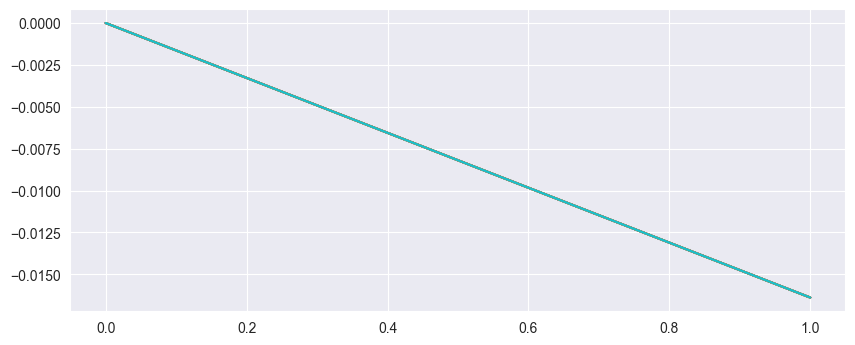

In [204]:
plt.figure(figsize=(10,4), dpi=100)
plt.plot( trajectories[:,:,0].T );

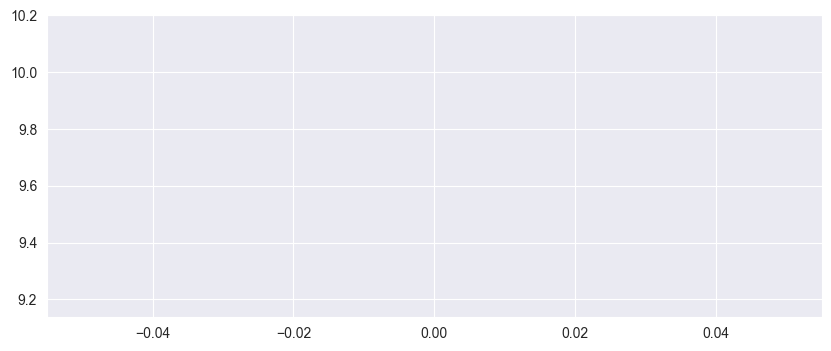

In [205]:
plt.figure(figsize=(10,4), dpi=100)
plt.plot( trajectories_act.T );